In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA
from rna_learn.load_sequences import (
    load_growth_temperatures, 
    compute_inverse_effective_sample,
    assign_weight_to_batch_values,
    SpeciesSequence,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model, DenormalizedMAE

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
run_id = 'run_lsko3'
model_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/model.h5')
metadata_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/metadata.json')

In [5]:
with open(metadata_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_lsko3',
 'alphabet': ['A', 'C', 'G', 'T'],
 'learning_rate': 0.0001,
 'batch_size': 64,
 'encoding_size': 20,
 'decoder_n_hidden': 100,
 'growth_rate': 15,
 'n_layers': 10,
 'kernel_sizes': [3, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'strides': None,
 'dilation_rates': None,
 'l2_reg': 1e-05,
 'dropout': 0.5,
 'n_epochs': 2,
 'seed': 7778,
 'val_loss': 1.4337137937545776,
 'val_mae': 12.203943252563477}

In [6]:
model = conv1d_densenet_regression_model(
    alphabet_size=len(metadata['alphabet']), 
    growth_rate=metadata['growth_rate'],
    n_layers=metadata['n_layers'],
    kernel_sizes=metadata['kernel_sizes'],
    dilation_rates=metadata['dilation_rates'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
    convert_to_tensor_fn=tfp.distributions.Distribution.mean,
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 15)     195         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 19)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 15)     1440        concat_1[0][0]        

## Load sequences from a single specie

In [7]:
query = """
select s.sequence, s.length, t.growth_tmp
from sequences as s
inner join species_traits as t
on t.species_taxid = s.species_taxid
where s.species_taxid = ?
"""
species_taxid = 11
species_df = pd.read_sql(query, engine, params=(species_taxid,))
len(species_df)

4517

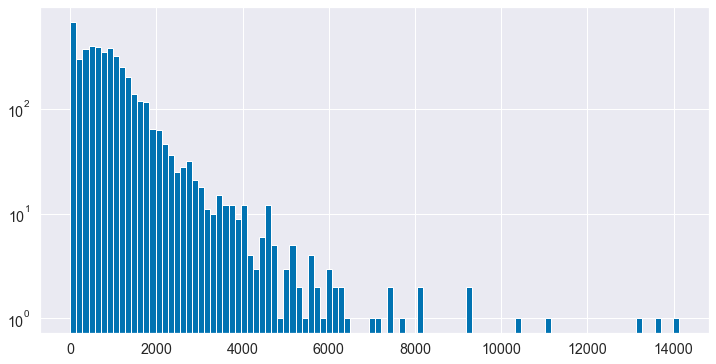

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(species_df['length'], bins=100, log=True);

In [9]:
species_df['growth_tmp'].iloc[0]

26.0

In [10]:
temperatures, mean, std = load_growth_temperatures(engine)

In [11]:
species_seq = SpeciesSequence(
    engine, 
    species_taxid=species_taxid,
    batch_size=64, 
    temperatures=temperatures,
    mean=mean,
    std=std,
    dtype='float32',
    alphabet=ALPHABET_DNA, 
    max_sequence_length=int(1e4),
    random_seed=444,
)

In [12]:
compile_regression_model(
    model, 
    learning_rate=1e-4,
    weighted_metrics=[
        DenormalizedMAE(
            mean=mean, 
            std=std,
            dtype='float32',
        )
    ],
)
model.load_weights(model_path)

In [17]:
predicted_temps_norm = model.predict(species_seq, verbose=1)

71/71 [==============================] - 13s 187ms/step


In [18]:
predicted_temps = denormalize(predicted_temps_norm, mean, std)
np.mean(predicted_temps)

109.45276